In [1]:
import pandas as pd
import ast
import numpy as np

In [2]:
def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)

train_barlines = pd.read_csv('deepscores_train_barlines.csv')

train_barlines['a_bbox'] = train_barlines['a_bbox'].apply(convert_str_to_list)
train_barlines['o_bbox'] = train_barlines['o_bbox'].apply(convert_str_to_list)

# Sort by 'filename' first, then by y-coordinate, then by x-coordinate
train_barlines = train_barlines.iloc[np.lexsort((train_barlines['o_bbox'].apply(lambda x: x[0]),
                                                 train_barlines['o_bbox'].apply(lambda x: x[1]),
                                                 train_barlines['filename']))]

# Getting the line number and measure numbers for barlines

In [3]:
# Function to detect if bboxes are on the same line
def on_same_line(bbox1, bbox2):
    # Extract the y-coordinates of the top left corner of the bounding boxes
    y1_top_left = bbox1[1]
    y2_top_left = bbox2[1]
    
    # Check if the y-coordinates are within a 1-2 pixel range
    return abs(y1_top_left - y2_top_left) <= 2

# Function to numerically encode the bar lines based on their y-coordinates
def process_group(group, filename):
    
    # Sort by y-coordinate first to group by line, then by x-coordinate to maintain left-to-right order
    # Assuming 'o_bbox' is a list with the structure [x1, y1, x2, y2, x3, y3, x4, y4]
    # where (x1, y1) are the coordinates for the top-left corner of the bbox
    group = group.sort_values(by=['o_bbox']).reset_index(drop=True)
    
    # Split the 'o_bbox' column into separate x and y columns for sorting
    group['x_coord'] = group['o_bbox'].apply(lambda x: x[0])  # x1 coordinate
    group['y_coord'] = group['o_bbox'].apply(lambda x: x[1])  # y1 coordinate
    group = group.sort_values(by=['y_coord', 'x_coord']).reset_index(drop=True)

    # Initialize line number
    line_number = 0
    group['line_number'] = line_number  # Initialize line number column
    
    # Iterate through each bbox
    for i in range(1, len(group)):
        # If the y-coordinates change significantly, it's a new line
        if not on_same_line(group.iloc[i-1]['o_bbox'], group.iloc[i]['o_bbox']):
            line_number += 1
            # probably error
            if line_number == 100:
                print(f"Line number exceeded 100 for {filename}")
        # Assign the current line number
        group.iat[i, group.columns.get_loc('line_number')] = line_number


    # Identify and remove redundant barlines
    max_x_per_line = group.groupby('line_number')['x_coord'].max()
    group = group[group.apply(lambda row: row['x_coord'] < max_x_per_line[row['line_number']], axis=1)]

    # Initialize measure numbers
    group['measure_number'] = -1  # Initialize with -1 to denote unassigned measures
    measure_number = 0

    group = group.sort_values(by=['y_coord', 'x_coord'], ascending=[True, False]).reset_index(drop=True)

    # Assign measure numbers by comparing each bbox to every other bbox
    for i in range(len(group)):
        # If measure number is already assigned, continue to the next
        if group.iat[i, group.columns.get_loc('measure_number')] != -1:
            continue
        
        # Assign the next measure number to this bbox
        group.iat[i, group.columns.get_loc('measure_number')] = measure_number
        
        # Iterate through all other bboxes to find those that belong to the same measure
        for j in range(len(group)):
            if i != j and group.iat[j, group.columns.get_loc('measure_number')] == -1:
                # Check if the bboxes are close in x-coordinates and have consecutive line numbers,
                if abs(group.iat[i, group.columns.get_loc('x_coord')] - group.iat[j, group.columns.get_loc('x_coord')]) <= 2 and \
                    abs(group.iat[i, group.columns.get_loc('line_number')] - group.iat[j, group.columns.get_loc('line_number')]) <= 10 and \
                    group.iat[i, group.columns.get_loc('line_number')] != group.iat[j, group.columns.get_loc('line_number')]:
                    # Assign the same measure number to the j-th bbox
                    group.iat[j, group.columns.get_loc('measure_number')] = measure_number
        
        # Increment the measure number after processing a group of bboxes that belong to the same measure
        measure_number += 1

        # probably error
        if measure_number == 200:
            print(f"Measure number exceeded 200 for {filename}")

    # Drop the helper columns after processing
    group.drop(['x_coord', 'y_coord'], axis=1, inplace=True)
    
    return group


# Group by 'filename' and apply the process_group function with sorting

# # The rest of your code remains the same.
# image_path = 'lg-102414375-aug-beethoven--page-2.png'
# train_barlines = train_barlines[train_barlines["filename"]==image_path]

train_barlines = train_barlines.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)

train_barlines = train_barlines.sort_values(by=['filename', 'line_number', 'measure_number'])

train_barlines.head(20)

TypeError: <lambda>() got an unexpected keyword argument 'include_groups'

In [ ]:
train_barlines = train_barlines.sort_values(by=['filename', 'line_number', 'measure_number'])

# Creating measures using barlines

In [ ]:
def group_measures_by_line(group):
    # Sort the group by line number and measure number
    sorted_group = group.sort_values(by=['line_number', 'measure_number'])

    # Dictionary to hold the bounding boxes grouped by line and measure
    bbox_groups = {}

    # Iterate over each line
    for line_number in sorted_group['line_number'].unique():
        line_data = sorted_group[sorted_group['line_number'] == line_number]
        
        # Iterate through the measures in the line
        for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
            current_measure = line_data.iloc[i]
            next_measure = line_data.iloc[i + 1]

            # Check if the next measure number is consecutive
            if current_measure['measure_number'] + 1 == next_measure['measure_number']:
                # Create the key as 'measure_current_current+1'
                key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                
                # If the key doesn't exist, create it and assign an empty list
                if key not in bbox_groups:
                    bbox_groups[key] = []

                # Append the current and next bounding boxes to the list under the key
                bbox_groups[key].append(current_measure['o_bbox'])
                bbox_groups[key].append(next_measure['o_bbox'])

    return bbox_groups


# test_df = train_barlines.loc[train_barlines["filename"] == 'lg-101766503886095953-aug-beethoven--page-1.png'].reset_index(drop=True)

# Now, group by 'filename' and apply the grouping function
grouped_bbox_data = train_barlines.groupby("filename").apply(group_measures_by_line, include_groups=False)

# Now, group by 'filename' and apply the grouping function
grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index().rename(columns={'level_0': 'filename', 'level_1': 'data'})

grouped_bbox_df.head()

# Calculating the vertices for each measure

In [4]:
# Function to process each dictionary and extract min/max coordinates
def calc_coordinates(bbox_dict):
    result = {}
    for key, bboxes in bbox_dict.items():
        min_x = min(min(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        min_y = min(min(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        max_x = max(max(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        max_y = max(max(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        result[key] = [min_x, min_y, max_x, min_y, max_x, max_y, min_x, max_y]
    return result

# Apply the function to each row in the 'o_bbox' column
grouped_bbox_df['measure_bbox'] = grouped_bbox_df[0].apply(calc_coordinates)

grouped_bbox_df.head()

NameError: name 'grouped_bbox_df' is not defined

- adding initial measures

In [5]:
def process_bboxes(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}

    for key, box in data.items():
        min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

        if  min_x < tolerance:
            break

        # This will be used to check if we have a similar y_key already in grouped_data
        similar_y_key_found = False

        # Check each y_key in grouped_data to see if it's within the tolerance level
        for y_key in grouped_data.keys():
            if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                # If found, update the similar y_key with the min of min_x values
                grouped_data[y_key] = min(grouped_data[y_key], min_x)
                similar_y_key_found = True
                break

        # If no similar y_key was found, add this box as a new entry
        if not similar_y_key_found:
            grouped_data[(min_y, max_y)] = min_x
    
    # Form the new bounding boxes using the real min_x and the y_key values
    new_bboxes = {}
    count = 0
    for y_key, real_min_x in grouped_data.items():
        if real_min_x == 0:
            continue
        new_key = f"initial_measure_{count}"
        data[new_key] = [0, y_key[0], real_min_x, y_key[0], real_min_x, y_key[1], 0, y_key[1]]
        count += 1

    return data

# Apply the function to the DataFrame
grouped_bbox_df['new_measure_bbox'] = grouped_bbox_df['measure_bbox'].apply(process_bboxes)

NameError: name 'grouped_bbox_df' is not defined

- adding final measures

In [6]:
def process_bboxes(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}

    for key, box in data.items():
        min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

        # This will be used to check if we have a similar y_key already in grouped_data
        similar_y_key_found = False

        # Check each y_key in grouped_data to see if it's within the tolerance level
        for y_key in grouped_data.keys():
            if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                # If found, update the similar y_key with the min of min_x values
                grouped_data[y_key] = max(grouped_data[y_key], max_x)
                similar_y_key_found = True
                break

        # If no similar y_key was found, add this box as a new entry
        if not similar_y_key_found:
            grouped_data[(min_y, max_y)] = max_x
    
    # Form the new bounding boxes using the real min_x and the y_key values
    new_bboxes = {}
    count = 0
    for y_key, real_max_x in grouped_data.items():

        new_key = f"final_measure_{count}"
        data[new_key] = [1960, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], 1960, y_key[1]]
        count += 1

    return data

# Apply the function to the DataFrame
grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df['new_measure_bbox'].apply(process_bboxes)

NameError: name 'grouped_bbox_df' is not defined

In [7]:
grouped_bbox_df.head()

NameError: name 'grouped_bbox_df' is not defined

# **TEST**

In [439]:
# The rest of your code remains the same.
image_path = 'lg-101766503886095953-aug-beethoven--page-1.png'

# Filtering
test_df = train_barlines[train_barlines["filename"]==image_path]

test_df = test_df.sort_values(by=['line_number', 'measure_number'])

test_df = test_df.reset_index()

test_df

,index,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask,line_number,measure_number
0,0,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1390.0, 377.0, 1387.0, 443.0, ...","[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1390.0, 377.0, 1387.0, 443.0, ...",198.0,-1,-1,-5157,156,-1,0,0,0,0,0
1,1,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 913.0, 377.0, 910.0, 443.0, 913...","[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 913.0, 377.0, 910.0, 443.0, 913...",198.0,-1,-1,-5158,156,-1,0,0,0,0,1
2,2,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1390.0, 606.0, 1387.0, 671.0, ...","[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1390.0, 606.0, 1387.0, 671.0, ...",195.0,-1,-1,-5153,156,-1,0,0,0,1,0
3,3,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 913.0, 606.0, 910.0, 671.0, 913...","[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 913.0, 606.0, 910.0, 671.0, 913...",195.0,-1,-1,-5154,156,-1,0,0,0,1,1
4,5,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1390.0, 834.0, 1387.0, 899.0, ...","[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1390.0, 834.0, 1387.0, 899.0, ...",195.0,-1,-1,-5150,156,-1,0,0,0,2,0
5,4,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 913.0, 833.0, 910.0, 900.0, 913...","[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 913.0, 833.0, 910.0, 900.0, 913...",201.0,-1,-1,-5152,156,-1,0,0,0,2,1
6,6,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1390.0, 1027.0, 1387.0, 1092....","[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1390.0, 1027.0, 1387.0, 1092....",195.0,-1,-1,-5147,156,-1,0,0,0,3,0
7,7,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 913.0, 1027.0, 910.0, 1092.0, ...","[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 913.0, 1027.0, 910.0, 1092.0, ...",195.0,-1,-1,-5148,156,-1,0,0,0,3,1
8,8,lg-101766503886095953-aug-beethoven--page-1.png,"[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1468.0, 1754.0, 1465.0, 1819....","[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1468.0, 1754.0, 1465.0, 1819....",195.0,-1,-1,-5143,156,-1,0,0,0,4,2
9,9,lg-101766503886095953-aug-beethoven--page-1.png,"[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1067.0, 1754.0, 1064.0, 1820....","[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1067.0, 1754.0, 1064.0, 1820....",198.0,-1,-1,-5146,156,-1,0,0,0,4,3


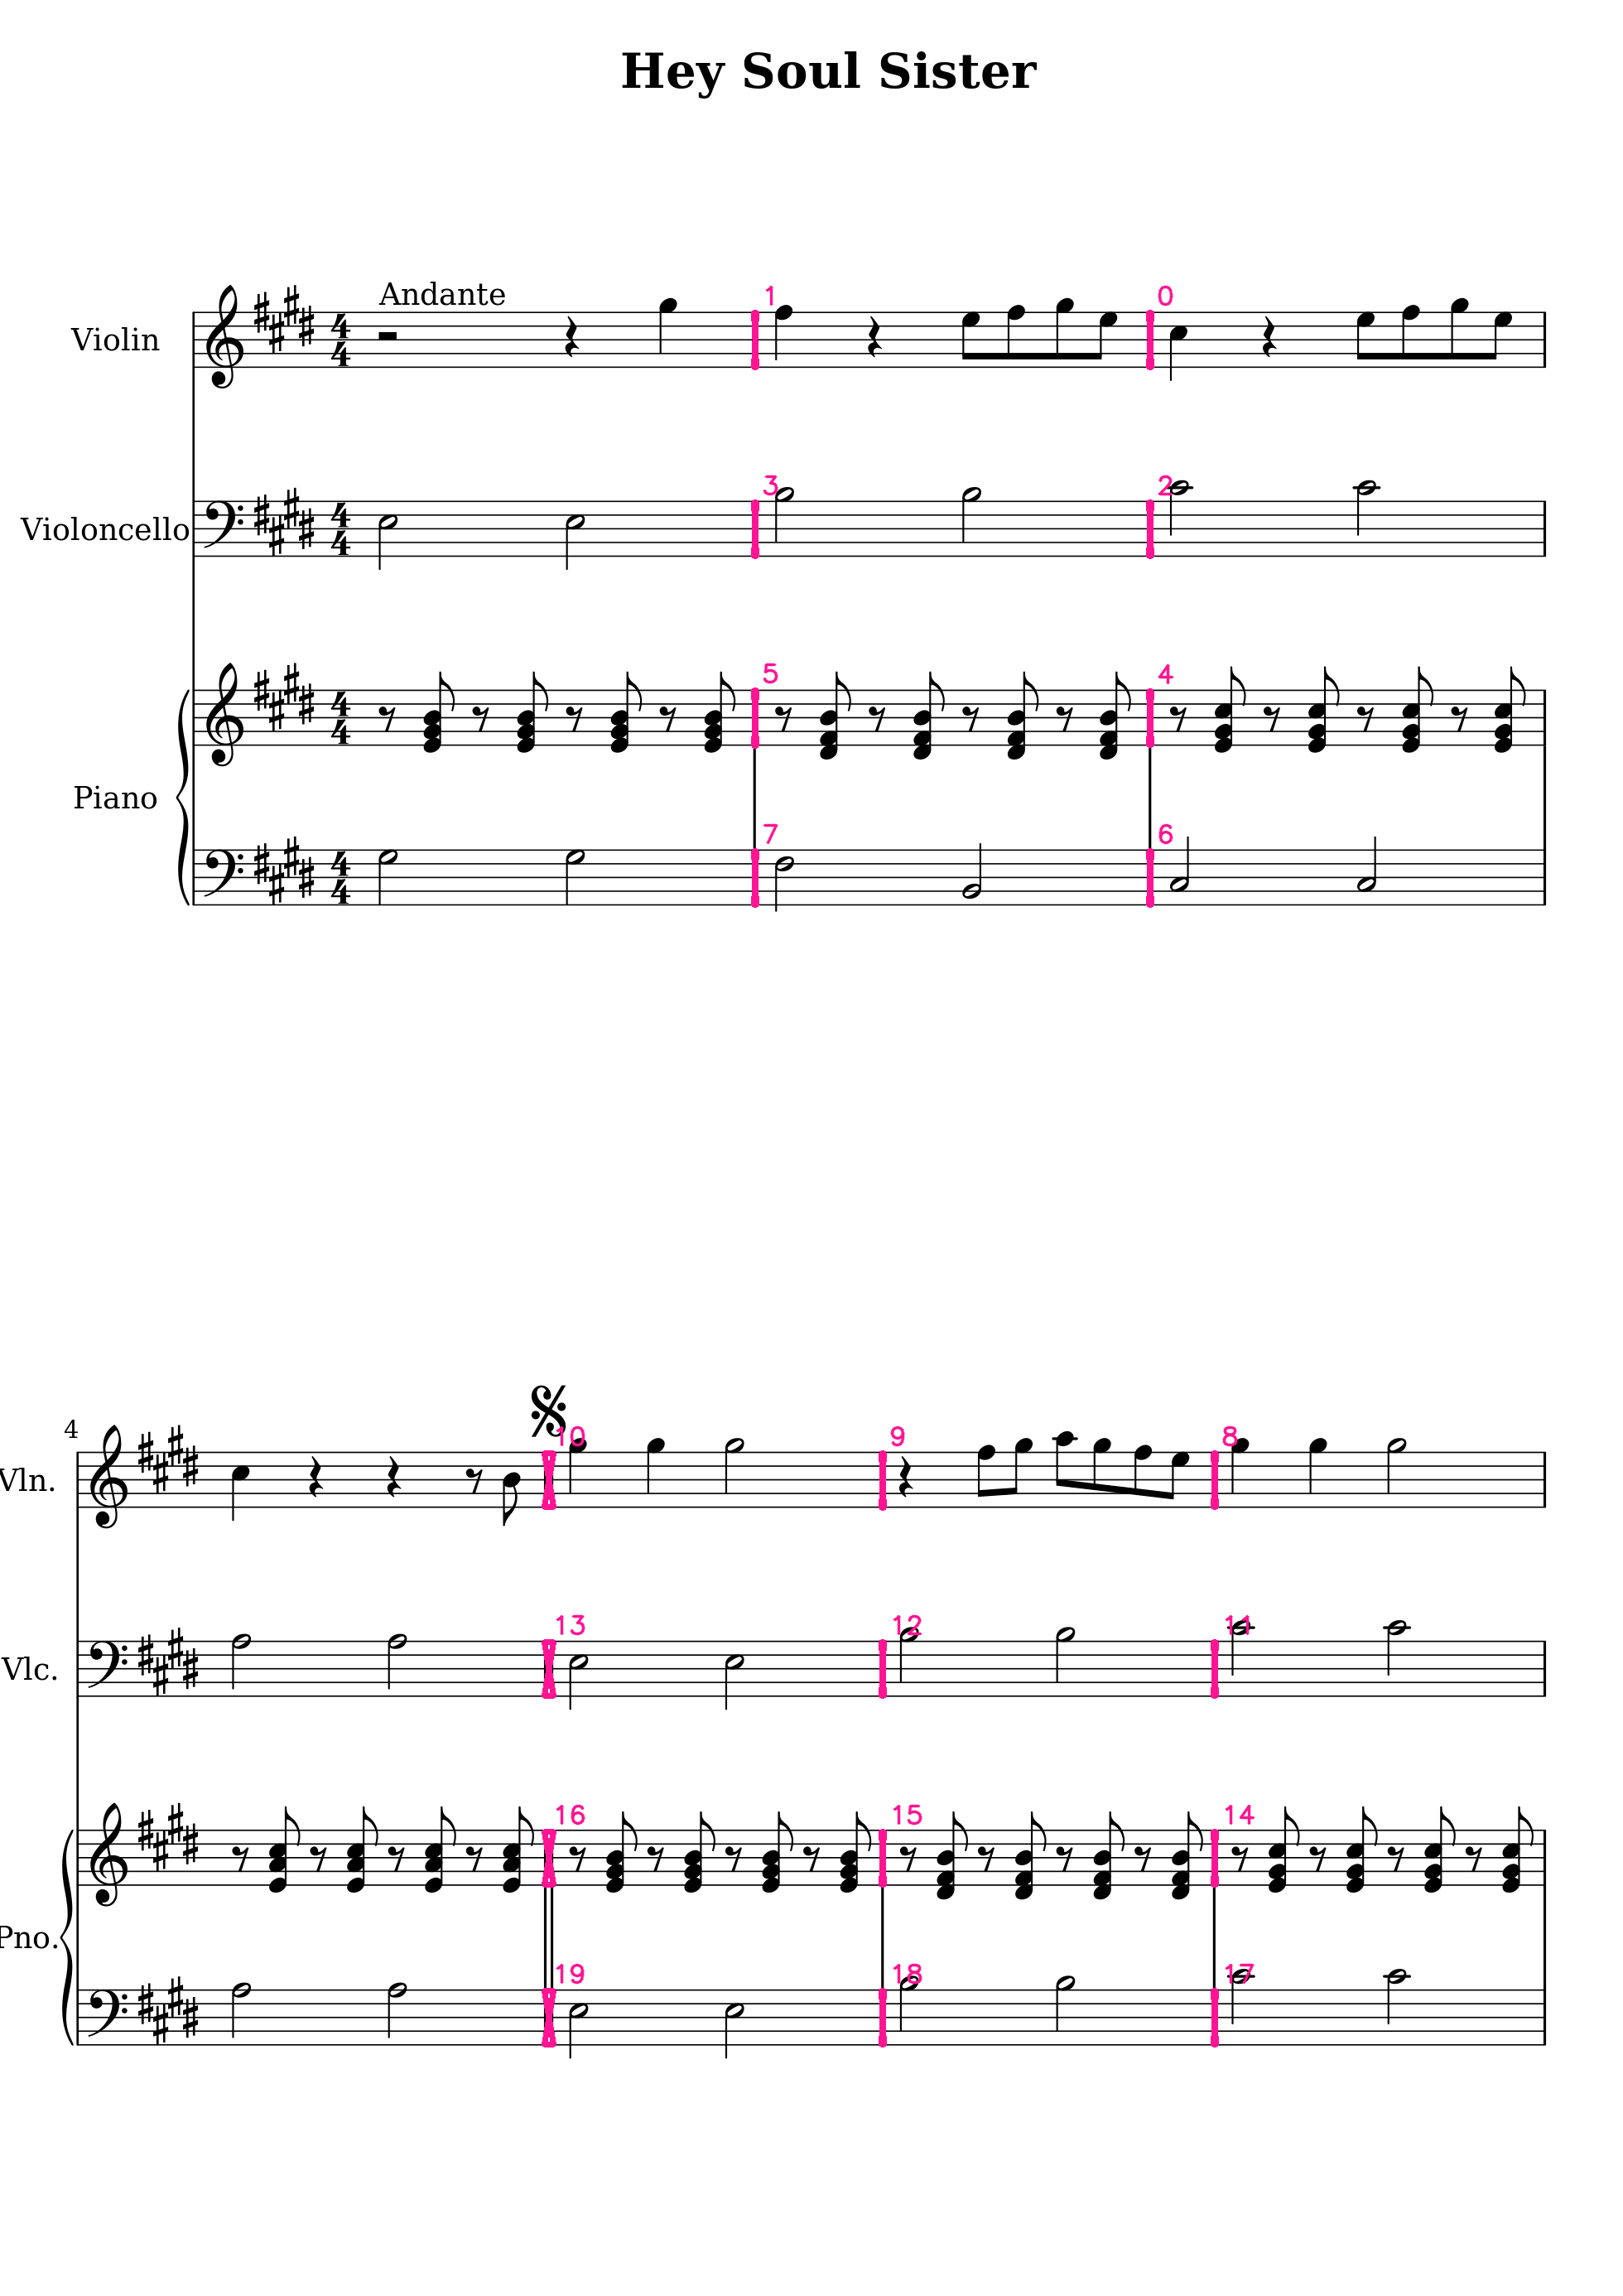

In [440]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image

def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for index, row in data.iterrows():
        points = np.array(row['o_bbox'], dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        # Calculate the position for text (putting it at the center of the polygon)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the polygon
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(index), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image


result_image = draw_rectangles(image_path, test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))

In [441]:
test_df = grouped_bbox_df[grouped_bbox_df["filename"]==image_path]['new_measure_bbox_updated'].values[0]

test_df

{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, 1390.0, 1092.0, 910.0, 1092.0],
 'measure_2_3': [1064.0,
  1754.0,
  1468.0,
  1754.0,
  1468.0,
  2468.0,
  1064.0,
  2468.0],
 'measure_3_4': [657.0, 1754.0, 1067.0, 1754.0, 1067.0, 2468.0, 657.0, 2468.0],
 'initial_measure_0': [0, 377.0, 910.0, 377.0, 910.0, 1092.0, 0, 1092.0],
 'initial_measure_1': [0, 1754.0, 657.0, 1754.0, 657.0, 2468.0, 0, 2468.0],
 'final_measure_0': [1960, 377.0, 1390.0, 377.0, 1390.0, 1092.0, 1960, 1092.0],
 'final_measure_1': [1960,
  1754.0,
  1468.0,
  1754.0,
  1468.0,
  2468.0,
  1960,
  2468.0]}

initial_measure_0 [0, 377.0, 910.0, 377.0, 910.0, 1092.0, 0, 1092.0]
initial_measure_1 [0, 1754.0, 657.0, 1754.0, 657.0, 2468.0, 0, 2468.0]


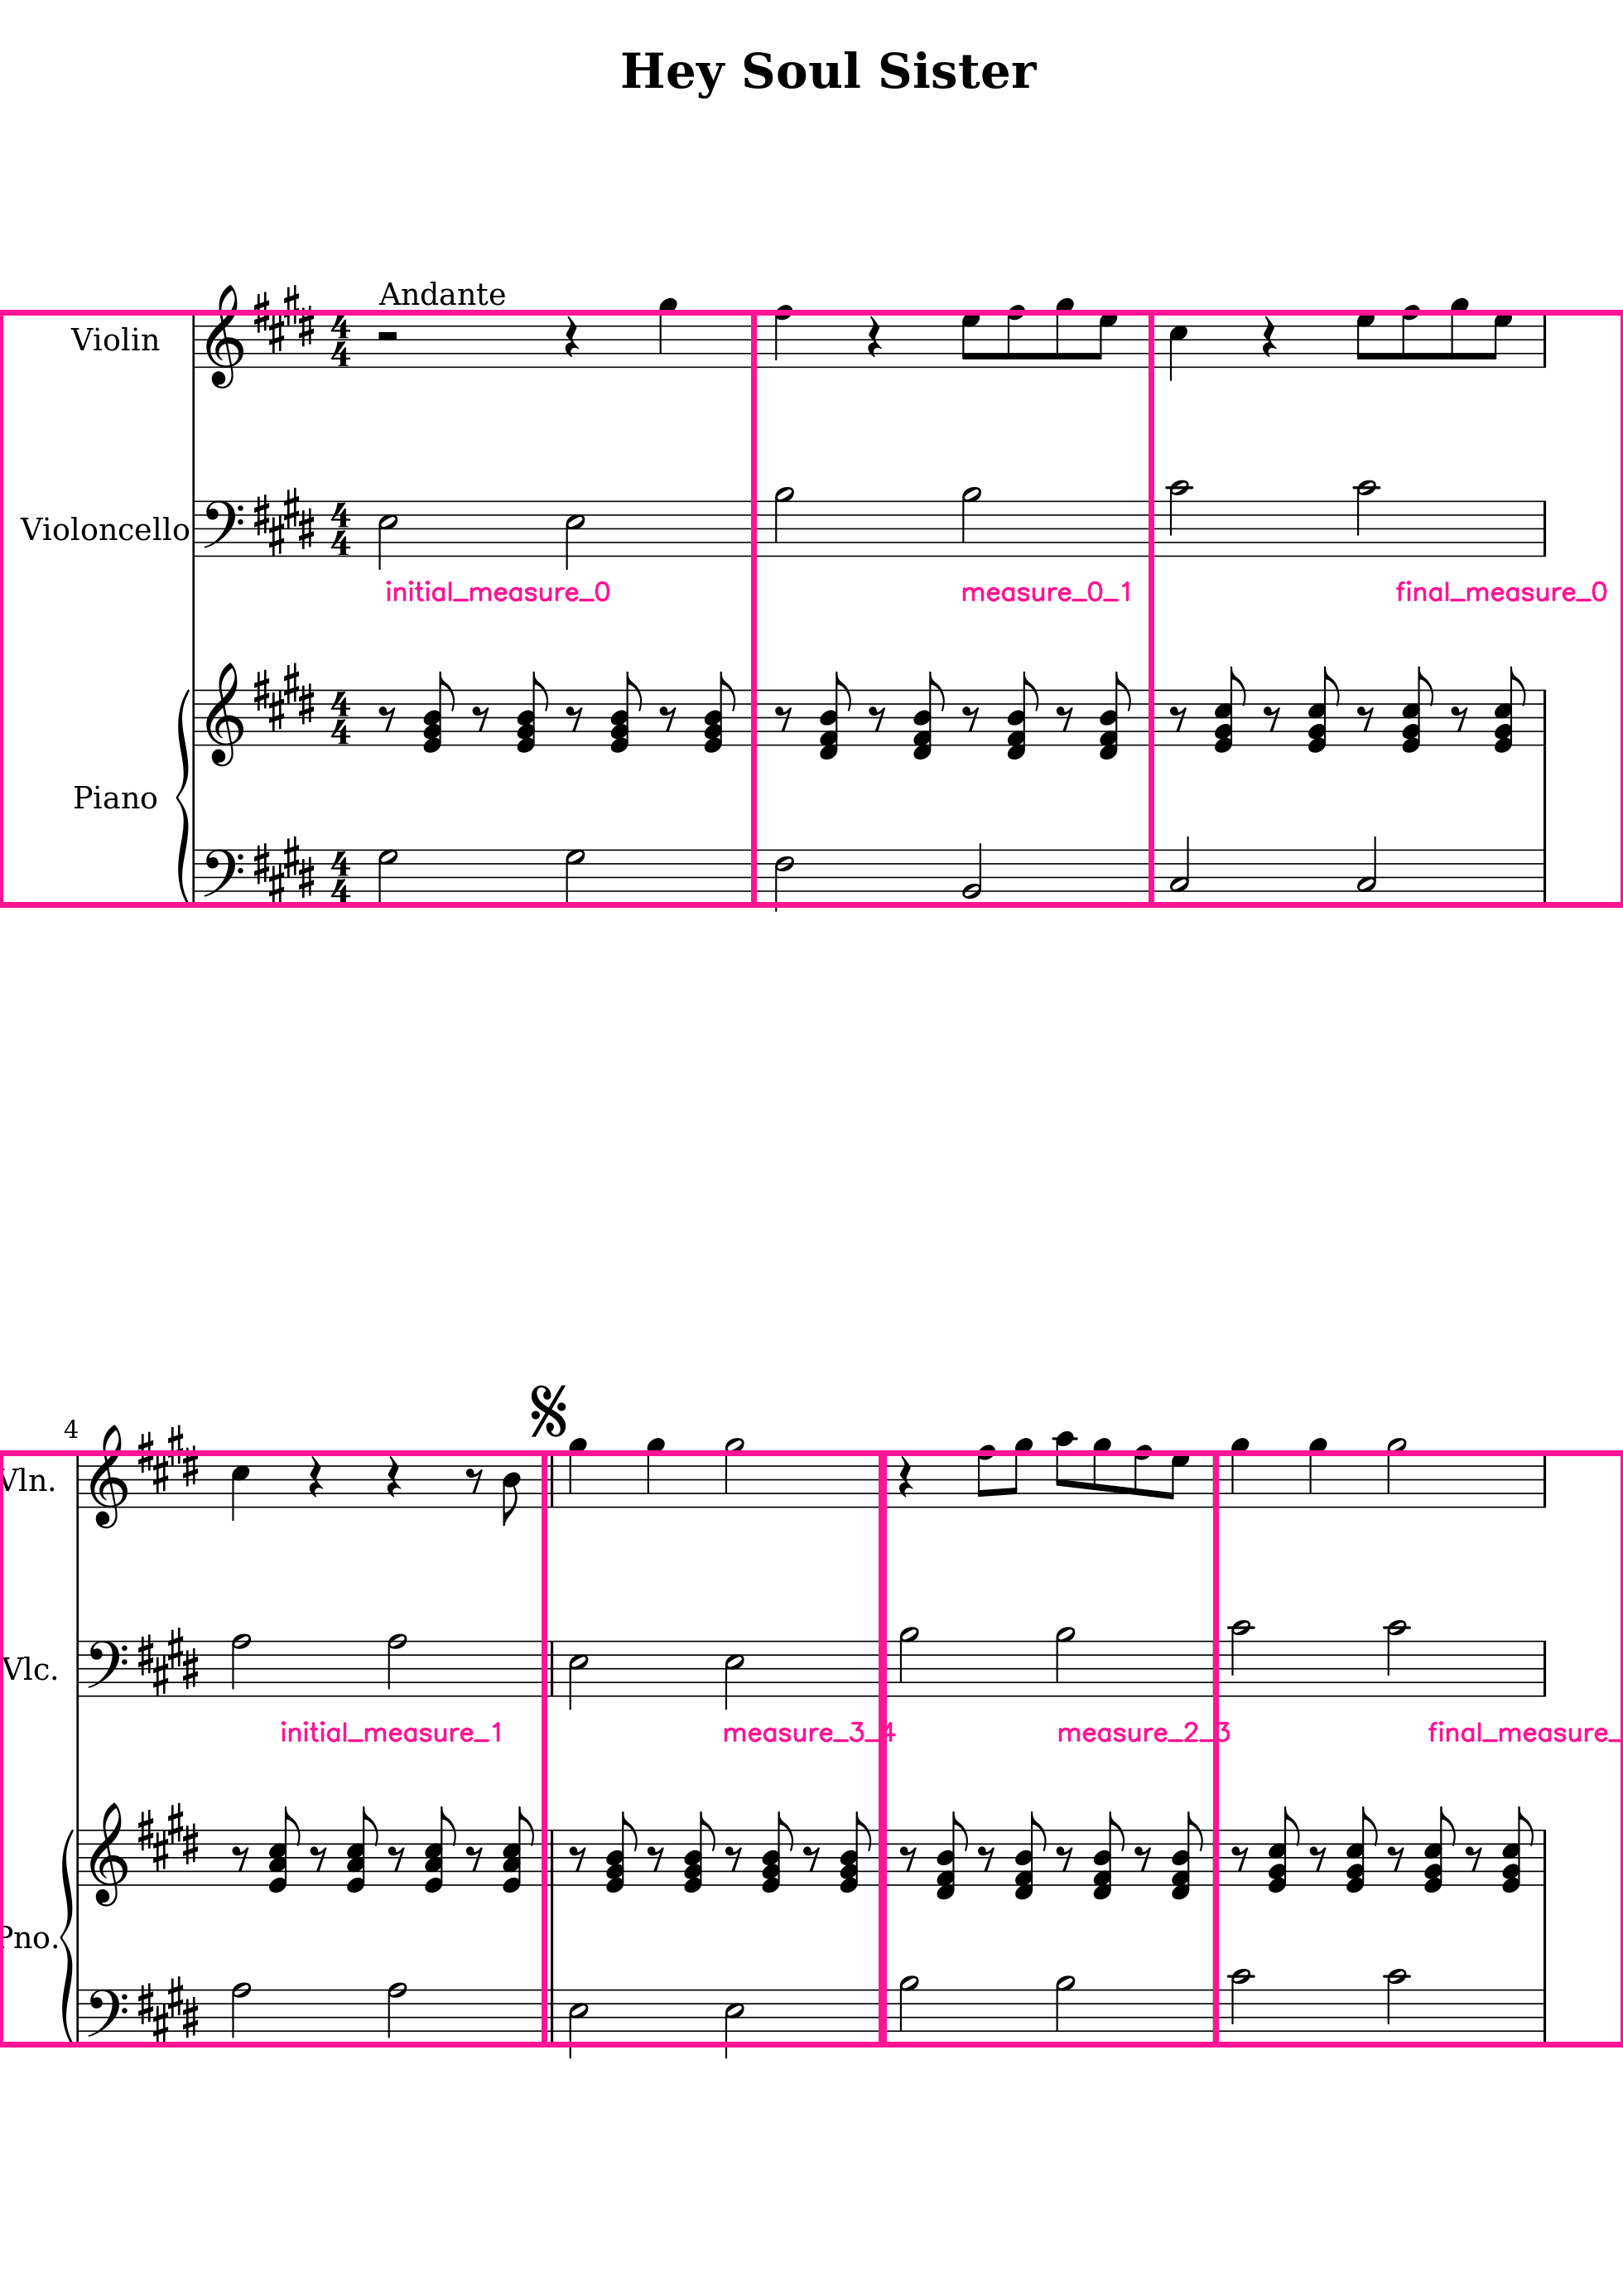

In [442]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image


def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for key, coordinates in data.items():
        points = np.array(coordinates, dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        if key.startswith('initial_measure'):
            print(key, coordinates)
        # Calculate the position for text (putting it at the center of the box)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the box
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(key), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image

# Filtering
test_df = grouped_bbox_df[grouped_bbox_df["filename"]==image_path]['new_measure_bbox_updated'].values[0]

result_image = draw_rectangles(image_path, test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))